In [1]:
# -*- coding: utf-8 -*-
import dataiku
import pandas as pd, numpy as np
from dataiku import pandasutils as pdu

import matplotlib.pyplot as plt

# ***************************************
#
# This function calculates and observes retention rates for 2019-2023
# and then forecasts retention rates for 2023-2035
# and then uses the 2019-2035 retention rates to estimate EXEPECTED/AVG RETENTION
#
# Input Data Set to this function:
# NAFCUSTOMER_REVENUE_AGGREGATED
# Each row represents one customer per year/month
# dimensions: customer name, setup date, BI_CUS_PAR, BI_PRODUCT, BI_MRU
# measures: revenue, spend, gallons, active cards and outstanding cards
#
# **************************************
#
# The data going into this step is defined in the follopwing Input View:
#
#  CREATE VIEW DATAIKU_ANALYTICS_SUB.DATA_SCIENCE.NAFCUSTOMER_REVENUE_AGGREGATED
#  AS
#  SELECT
#  CUSTOMER_ID,
#  CUSTOMER,
#  YEAR(REVENUE_DATE) as REVENUE_YEAR,
#  MONTH(REVENUE_DATE) as REVENUE_MONTH,
#  MIN(SETUP_DATE) AS SETUP_DATE,
#  MIN(BI_CUS_PAR) as BI_CUS_PAR,
#  MIN(BI_PRODUCT) as BI_PRODUCT,
#  MIN(BI_MRU) as BI_MRU,
#  SUM(REVENUE_AMOUNT_USD) as REVENUE_AMOUNT_USD,
#  SUM(GROSS_SPEND_AMOUNT) as GROSS_SPEND_AMOUNT,
#  SUM(PURCHASE_GALLONS_QTY) PURCHASE_GALLONS_QTY,
#  SUM(TOTAL_ACTIVE_CARD_COUNT) as TOTAL_ACTIVE_CARD_COUNT
#  FROM DATAIKU_ANALYTICS_SUB.DATA_SCIENCE.NAFCUSTOMER_REVENUE
#  WHERE (FUNDED_BY IS NULL OR FUNDED_BY='Unknown' OR FUNDED_BY='WEX Funded')
#  AND (NOT((REVENUE_CODE='26') AND (CUSTOMER_ID IS NULL)))
#  AND (NOT((REVENUE_CODE='E8') AND (CUSTOMER_ID IS NULL)))
#  GROUP BY 1,2,3,4
#
# ***************************************

from datetime import date, datetime, timedelta
import time

t0 = time.time()

# Read recipe inputs
NAFCUSTOMER_REVENUE_AGGREGATED = dataiku.Dataset("NAFCUSTOMER_REVENUE_AGGREGATED")
NAFCUSTOMER_REVENUE_AGGREGATED_df = NAFCUSTOMER_REVENUE_AGGREGATED.get_dataframe()

t1 = time.time()
print("load duration", (t1-t0)/60.0, "minutes")

print(len(NAFCUSTOMER_REVENUE_AGGREGATED_df))
NAFCUSTOMER_REVENUE_AGGREGATED_df.head()

load duration 6.088521635532379 minutes
18075044


,CUSTOMER_ID,CUSTOMER,REVENUE_YEAR,REVENUE_MONTH,SETUP_DATE,BI_CUS_PAR,BI_PRODUCT,BI_MRU,REVENUE_AMOUNT_USD,GROSS_SPEND_AMOUNT,PURCHASE_GALLONS_QTY,TOTAL_ACTIVE_CARD_COUNT
0,77244476.0,GATORS LAWN LANDSCAPING SVC,2021,11,2017-03-31 07:00:00+00:00,51200.0,15308.0,4120.0,0.000000,0.00,0.0000,0.0
1,77532829.0,SIECK WHOLESALE FLORIST,2021,10,2001-08-22 07:00:00+00:00,51000.0,10100.0,3100.0,371.760000,7747.75,2319.4830,14.0
2,77385040.0,MAYWOOD CHURCH OF CHRIST,2019,4,2010-10-14 07:00:00+00:00,13000.0,15100.0,4000.0,21.290000,108.90,31.7740,1.0
3,77561771.0,SUN ON FOOD CO LTD,2021,8,2011-11-11 08:00:00+00:00,20800.0,15100.0,4000.0,22.630000,2285.22,573.8035,4.0
4,77308677.0,JAKE KAUFFMAN SON INC,2021,1,2011-12-01 08:00:00+00:00,30400.0,15308.0,4120.0,1.304844,40.05,17.2020,1.0


In [2]:
# create a copy of the input dataset
# this leaves the original dataset in memory and allows for a quick reload without having to back to Snowflake

print(len(NAFCUSTOMER_REVENUE_AGGREGATED_df), "rows in NAFCUSTOMER_REVENUE_AGGREGATED")
df = NAFCUSTOMER_REVENUE_AGGREGATED_df.copy()

18075044 rows in NAFCUSTOMER_REVENUE_AGGREGATED


In [3]:
# Prep data
#
# cast year to integer and create a revenue date column using month and year
#

df['CUSTOMER_ID'] = df['CUSTOMER_ID'].astype('Int64')
df['SETUP_DATE_DT'] = pd.to_datetime(df['SETUP_DATE'])
df['SETUP_YEAR'] = df.SETUP_DATE_DT.dt.year

df['REVENUE_YEAR'] = df['REVENUE_YEAR'].astype('Int64')
df['REVENUE_DATE'] = df['REVENUE_MONTH'].astype(str) + '-' + df['REVENUE_YEAR'].astype(str)
df['REVENUE_DATE'] = pd.to_datetime(df['REVENUE_DATE'], format='%m-%Y').dt.strftime('%m-%Y')

#
# filter out Jan 2023 as it represents only a partial year
#

print(len(df), "before filter")
df = df[df.REVENUE_YEAR!=2023]
print(len(df), "after filter, removing 2023")

# break down of revenue_year
df.REVENUE_YEAR.value_counts()

18075044 before filter
17673397 after filter, removing 2023


2022    4836440
2021    4517640
2020    4243565
2019    4075752
Name: REVENUE_YEAR, dtype: Int64

In [86]:
df.CUSTOMER_ID.nunique()

650886

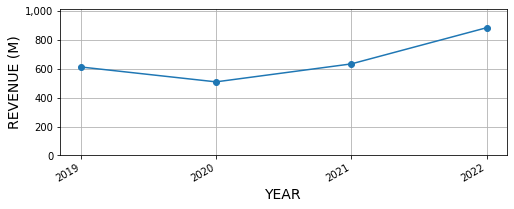

,REVENUE_YEAR,REVENUE_AMOUNT_USD
0,2019,611.886394
1,2020,508.936503
2,2021,633.153609
3,2022,883.299242


In [5]:
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

# plot out sum of revenue per year
# in order to do a quick reonciliation against 

# aggregate revenue at annual grain
df_revenue_per_year = df.groupby(['REVENUE_YEAR']).REVENUE_AMOUNT_USD.sum().reset_index()
df_revenue_per_year.REVENUE_AMOUNT_USD = df_revenue_per_year.REVENUE_AMOUNT_USD/1000000
df_revenue_per_year.head()

max_revenue = df_revenue_per_year.REVENUE_AMOUNT_USD.max()

chart_revenue_year = [] 
for y in df_revenue_per_year.REVENUE_YEAR.tolist():
    chart_revenue_year.append(str(y))
    
fig, ax1 = plt.subplots(figsize=(8,3))
ax1.plot(chart_revenue_year,df_revenue_per_year['REVENUE_AMOUNT_USD'], marker='o')
ax1.set_xlabel('YEAR', fontsize=14)
ax1.set_ylabel('REVENUE (M)', fontsize=14)
ax1.grid()
ax1.set_ylim(ymin=0, ymax=max_revenue*1.15)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
fig.autofmt_xdate()
#ax1.xaxis.set_major_locator(mdates.YearLocator())
plt.show()

df_revenue_per_year.head()

In [7]:
df_customer_monthly_card_count = df.groupby(['CUSTOMER_ID','REVENUE_DATE']).TOTAL_ACTIVE_CARD_COUNT.sum().reset_index()

df_customer_max_monthly_card_sum = df.groupby(['CUSTOMER_ID']).TOTAL_ACTIVE_CARD_COUNT.max().reset_index()
df_customer_max_monthly_card_sum['CUSTOMER_FLEET_SIZE'] = 'NOT SET'
df_customer_max_monthly_card_sum.loc[df_customer_max_monthly_card_sum["TOTAL_ACTIVE_CARD_COUNT"]>1700,'CUSTOMER_FLEET_SIZE'] = "XL (>1700 Cards)"
df_customer_max_monthly_card_sum.loc[(df_customer_max_monthly_card_sum["TOTAL_ACTIVE_CARD_COUNT"]>115)&(df_customer_max_monthly_card_sum["TOTAL_ACTIVE_CARD_COUNT"]<=1700),'CUSTOMER_FLEET_SIZE'] = "L (>115 and <=1700 Cards)"
df_customer_max_monthly_card_sum.loc[(df_customer_max_monthly_card_sum["TOTAL_ACTIVE_CARD_COUNT"]>21)&(df_customer_max_monthly_card_sum["TOTAL_ACTIVE_CARD_COUNT"]<=115),'CUSTOMER_FLEET_SIZE'] = "M (>21 and <=115 Cards)"
df_customer_max_monthly_card_sum.loc[(df_customer_max_monthly_card_sum["TOTAL_ACTIVE_CARD_COUNT"]<=21),'CUSTOMER_FLEET_SIZE'] = "S (<=21 Cards)"
df_customer_max_monthly_card_sum.loc[(df_customer_max_monthly_card_sum["TOTAL_ACTIVE_CARD_COUNT"]==0),'CUSTOMER_FLEET_SIZE'] = "No Cards"
df_customer_max_monthly_card_sum.loc[df_customer_max_monthly_card_sum["TOTAL_ACTIVE_CARD_COUNT"].isnull(),'CUSTOMER_FLEET_SIZE'] = "No Cards"

df_customer_max_monthly_card_sum.CUSTOMER_FLEET_SIZE.value_counts(dropna=False)

S (<=21 Cards)               521977
No Cards                      80904
M (>21 and <=115 Cards)       40936
L (>115 and <=1700 Cards)      6735
XL (>1700 Cards)                334
Name: CUSTOMER_FLEET_SIZE, dtype: int64

In [52]:
df_customer_max_monthly_card_sum.head()

,CUSTOMER_ID,TOTAL_ACTIVE_CARD_COUNT,CUSTOMER_FLEET_SIZE
0,77000000,0.0,No Cards
1,77000001,2.0,S (<=21 Cards)
2,77000002,3.0,S (<=21 Cards)
3,77000003,21.0,S (<=21 Cards)
4,77000004,2.0,S (<=21 Cards)


In [36]:
# Fleet Sizes
# zero cards : 0
# small      : 1-20
# medium     : 21-114
# large      : 115-1700
# X-Large    : > 1700

df_monthly_card_count = df.groupby(['CUSTOMER_ID','REVENUE_DATE']).TOTAL_ACTIVE_CARD_COUNT.sum().reset_index()
df_max_monthly_card_count = df_monthly_card_count.groupby(['CUSTOMER_ID']).TOTAL_ACTIVE_CARD_COUNT.max().reset_index()

df_max_monthly_card_count.TOTAL_ACTIVE_CARD_COUNT = df_max_monthly_card_count.TOTAL_ACTIVE_CARD_COUNT.astype('Int64')

df_max_monthly_card_count['FLEET_SIZE'] = 'not set'
df_max_monthly_card_count.loc[df_max_monthly_card_count.TOTAL_ACTIVE_CARD_COUNT<=0,'FLEET_SIZE'] = 'zero cards'
df_max_monthly_card_count.loc[df_max_monthly_card_count.TOTAL_ACTIVE_CARD_COUNT.between(1,20),'FLEET_SIZE'] = 'small 1-20'
df_max_monthly_card_count.loc[df_max_monthly_card_count.TOTAL_ACTIVE_CARD_COUNT.between(21,114),'FLEET_SIZE'] = 'medium 21-114'
df_max_monthly_card_count.loc[df_max_monthly_card_count.TOTAL_ACTIVE_CARD_COUNT.between(115,1700),'FLEET_SIZE'] = 'large 115-1700'
df_max_monthly_card_count.loc[df_max_monthly_card_count.TOTAL_ACTIVE_CARD_COUNT>1700,'FLEET_SIZE'] = 'extra large >1700'

df_max_monthly_card_count.head()

,CUSTOMER_ID,TOTAL_ACTIVE_CARD_COUNT,FLEET_SIZE
0,77000000,0,zero cards
1,77000001,2,small 1-20
2,77000002,3,small 1-20
3,77000003,21,medium 21-114
4,77000004,2,small 1-20


In [75]:
df_customer_min_setup = df.groupby(['CUSTOMER_ID']).SETUP_YEAR.min().reset_index()
df_customer_min_setup.head()

,CUSTOMER_ID,SETUP_YEAR
0,77000000,2012
1,77000001,2022
2,77000002,2018
3,77000003,2022
4,77000004,2018


In [38]:
df_fleet_size_customer_count = df_max_monthly_card_count.groupby(['FLEET_SIZE']).CUSTOMER_ID.nunique().reset_index()
df_fleet_size_customer_count.columns = ['FLEET_SIZE', 'CUSTOMER_COUNT']
df_fleet_size_customer_count.head()

,FLEET_SIZE,CUSTOMER_COUNT
0,extra large >1700,334
1,large 115-1700,6804
2,medium 21-114,43359
3,small 1-20,519485
4,zero cards,80904


In [41]:
df_fleet_size_card_count = df_max_monthly_card_count.groupby(['FLEET_SIZE']).TOTAL_ACTIVE_CARD_COUNT.sum().reset_index()
df_fleet_size_card_count.head()

,FLEET_SIZE,TOTAL_ACTIVE_CARD_COUNT
0,extra large >1700,2350046
1,large 115-1700,2054787
2,medium 21-114,1839215
3,small 1-20,2295256
4,zero cards,0


In [93]:
print(len(df))
df_activity = df[['CUSTOMER_ID','REVENUE_YEAR','REVENUE_DATE','PURCHASE_GALLONS_QTY','GROSS_SPEND_AMOUNT','REVENUE_AMOUNT_USD']].copy()
print(len(df_activity))

# drop nulls -- todo: figure out what these few null rows represent
df_activity = df_activity[~df_activity.CUSTOMER_ID.isnull()]
print(len(df_activity))

df_fleet_size = df_customer_max_monthly_card_sum[['CUSTOMER_ID','CUSTOMER_FLEET_SIZE']].copy()
df_fleet_size['CUSTOMER_ID'] = df_fleet_size['CUSTOMER_ID'].astype('Int64')

print(len(df_activity))
df_activity = pd.merge(df_activity, df_fleet_size, on='CUSTOMER_ID', how='left')
print(len(df_activity))

df_customer_min_setup['CUSTOMER_ID'] = df_customer_min_setup['CUSTOMER_ID'].astype('Int64')
df_activity = pd.merge(df_activity, df_customer_min_setup, on='CUSTOMER_ID', how='left')
print(len(df_activity))

df_activity.head(10)

17673397
17673397
17673363
17673363
17673363
17673363


,CUSTOMER_ID,REVENUE_YEAR,REVENUE_DATE,PURCHASE_GALLONS_QTY,GROSS_SPEND_AMOUNT,REVENUE_AMOUNT_USD,CUSTOMER_FLEET_SIZE,SETUP_YEAR
0,77244476,2021,11-2021,0.0000,0.00,0.000000,S (<=21 Cards),2017
1,77532829,2021,10-2021,2319.4830,7747.75,371.760000,M (>21 and <=115 Cards),2001
2,77385040,2019,04-2019,31.7740,108.90,21.290000,S (<=21 Cards),2010
3,77561771,2021,08-2021,573.8035,2285.22,22.630000,S (<=21 Cards),2011
4,77308677,2021,01-2021,17.2020,40.05,1.304844,S (<=21 Cards),2011
5,77012563,2020,02-2020,135.7834,466.04,4.550000,S (<=21 Cards),2015
6,77128284,2022,02-2022,309.2108,1457.76,12.480000,S (<=21 Cards),1983
7,77460264,2019,03-2019,433.1080,1181.76,13.420000,S (<=21 Cards),2013
8,77267881,2019,02-2019,10885.8180,22536.13,633.520000,M (>21 and <=115 Cards),2015
9,77458863,2021,11-2021,115.5000,695.05,35.340000,S (<=21 Cards),2015


In [124]:
df_max_monthly_card_count.head()

,CUSTOMER_ID,TOTAL_ACTIVE_CARD_COUNT,FLEET_SIZE
0,77000000,0,zero cards
1,77000001,2,small 1-20
2,77000002,3,small 1-20
3,77000003,21,medium 21-114
4,77000004,2,small 1-20


In [105]:
df_revenue_per_year = df_activity.groupby(['REVENUE_YEAR','CUSTOMER_FLEET_SIZE']).REVENUE_AMOUNT_USD.sum().reset_index()
df_revenue_per_year.head()

,REVENUE_YEAR,CUSTOMER_FLEET_SIZE,REVENUE_AMOUNT_USD
0,2019,L (>115 and <=1700 Cards),1.068596e+08
1,2019,M (>21 and <=115 Cards),1.817237e+08
2,2019,No Cards,8.308510e+06
3,2019,S (<=21 Cards),2.615362e+08
4,2019,XL (>1700 Cards),5.345842e+07


In [115]:
df_spend_per_year = df_activity.groupby(['REVENUE_YEAR','CUSTOMER_FLEET_SIZE']).GROSS_SPEND_AMOUNT.sum().reset_index()
df_spend_per_year.head()

,REVENUE_YEAR,CUSTOMER_FLEET_SIZE,GROSS_SPEND_AMOUNT
0,2019,L (>115 and <=1700 Cards),5.461103e+09
1,2019,M (>21 and <=115 Cards),4.999152e+09
2,2019,No Cards,1.425525e+08
3,2019,S (<=21 Cards),5.216579e+09
4,2019,XL (>1700 Cards),5.379123e+09


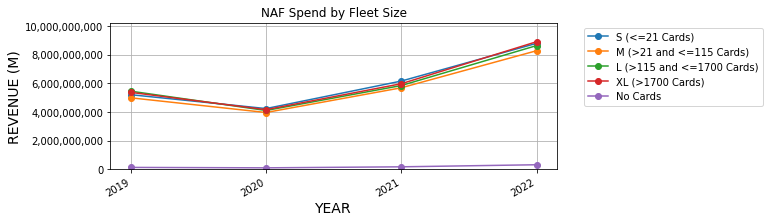

In [123]:
max_spend = df_spend_per_year.GROSS_SPEND_AMOUNT.max()
    
fig, ax1 = plt.subplots(figsize=(8,3))

df_spend_per_year['REVENUE_YEAR'] = df_spend_per_year['REVENUE_YEAR'].astype(str)

# s = df_revenue_per_year.CUSTOMER_FLEET_SIZE.unique()
# the following is this same list rearranged
groups = ['S (<=21 Cards)', 'M (>21 and <=115 Cards)', 'L (>115 and <=1700 Cards)','XL (>1700 Cards)','No Cards']

legend_items = []
for s in groups:
    ax1.plot(df_spend_per_year[df_spend_per_year.CUSTOMER_FLEET_SIZE==s].REVENUE_YEAR,
             df_spend_per_year[df_spend_per_year.CUSTOMER_FLEET_SIZE==s].GROSS_SPEND_AMOUNT, marker='o')
    legend_items.append(s)
    
ax1.set_xlabel('YEAR', fontsize=14)
ax1.set_ylabel('REVENUE (M)', fontsize=14)
ax1.grid()
ax1.set_ylim(ymin=0, ymax=max_spend*1.15)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
fig.autofmt_xdate()
plt.title('NAF Spend by Fleet Size')
plt.legend(legend_items, bbox_to_anchor=(1.05,1.0), loc='upper left')
plt.show()

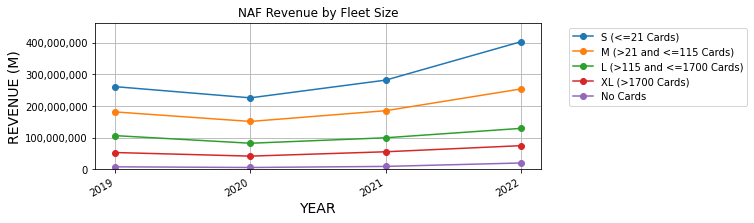

In [122]:
max_revenue = df_revenue_per_year.REVENUE_AMOUNT_USD.max()
    
fig, ax1 = plt.subplots(figsize=(8,3))

df_revenue_per_year['REVENUE_YEAR'] = df_revenue_per_year['REVENUE_YEAR'].astype(str)

# s = df_revenue_per_year.CUSTOMER_FLEET_SIZE.unique()
# the following is this same list rearranged so that the legend is ordered correctly
groups = ['S (<=21 Cards)', 'M (>21 and <=115 Cards)', 'L (>115 and <=1700 Cards)','XL (>1700 Cards)','No Cards']

legend_items = []
for s in groups:
    ax1.plot(df_revenue_per_year[df_revenue_per_year.CUSTOMER_FLEET_SIZE==s].REVENUE_YEAR,
             df_revenue_per_year[df_revenue_per_year.CUSTOMER_FLEET_SIZE==s].REVENUE_AMOUNT_USD, marker='o')
    legend_items.append(s)
    
ax1.set_xlabel('YEAR', fontsize=14)
ax1.set_ylabel('REVENUE (M)', fontsize=14)
ax1.grid()
ax1.set_ylim(ymin=0, ymax=max_revenue*1.15)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
fig.autofmt_xdate()
plt.title('NAF Revenue by Fleet Size')
plt.legend(legend_items, bbox_to_anchor=(1.05,1.0), loc='upper left')
plt.show()

Observed Average Retention Rate (2020-2022): 90.4 %


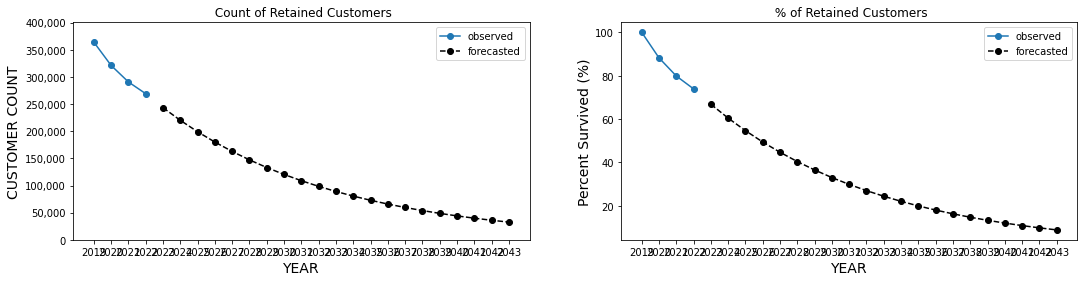

AVG Tenure (Observed + Forecasted): 9.47 Years
check_sum: 1.0


In [131]:
df_sub = df_activity[df_activity.SETUP_YEAR<2019]

df_sub = df_sub.groupby(['REVENUE_YEAR']).CUSTOMER_ID.nunique().reset_index()
df_sub.columns = ['REVENUE_YEAR','CUSTOMER_COUNT']
df_sub.REVENUE_YEAR = df_sub.REVENUE_YEAR.astype(str)
df_sub.CUSTOMER_COUNT = df_sub.CUSTOMER_COUNT.astype('Int64')

df_sub['SURVIVED_FROM_FIRST'] = (df_sub.CUSTOMER_COUNT / df_sub.iloc[0].CUSTOMER_COUNT)
df_sub['SURVIVED_FROM_FIRST_PERCENT'] = (df_sub.CUSTOMER_COUNT / df_sub.iloc[0].CUSTOMER_COUNT)*100
df_sub['CUSTOMERS_LEFT'] = 0

row_count = len(df_sub)

row_index = 0
retention_observations = []
for i in range(row_count):
    if i>0:
        survived = df_sub.iloc[i].CUSTOMER_COUNT / df_sub.iloc[i-1].CUSTOMER_COUNT
        df_sub.loc[i,'SURVIVED_FROM_PREV'] = survived
        df_sub.loc[i,'CUSTOMERS_LEFT'] = df_sub.iloc[i-1].CUSTOMER_COUNT - df_sub.iloc[i].CUSTOMER_COUNT
        retention_observations.append(survived)
    row_index+=1
        
avg_retention_rate = sum(retention_observations)/len(retention_observations)                
print("Observed Average Retention Rate (2020-2022):", 100*round(avg_retention_rate,3), "%")

forecast_year = 2022

df_sub['FORECAST_CUSTOMER_COUNT'] = np.nan
df_sub['FORECAST_FROM_FIRST_PERCENT'] = np.nan

forecast_years = 20

for i in range(forecast_years+1):

    forecast_year += 1
    if i==0:
        forecast_customer_count = round(avg_retention_rate * df_sub.iloc[i+row_count-1].CUSTOMER_COUNT,0)
        customers_left = df_sub.iloc[i+row_count-1].CUSTOMER_COUNT - forecast_customer_count
    else:
        forecast_customer_count = round(avg_retention_rate * df_sub.iloc[i+row_count-1].FORECAST_CUSTOMER_COUNT,0)
        customers_left = df_sub.iloc[i+row_count-1].FORECAST_CUSTOMER_COUNT - forecast_customer_count
    
    forecast_from_first_percent = (forecast_customer_count/df_sub.iloc[0].CUSTOMER_COUNT)*100
        
    dict = {'REVENUE_YEAR':forecast_year,'CUSTOMERS_LEFT': customers_left, 'SURVIVED_FROM_PREV': avg_retention_rate, 'FORECAST_CUSTOMER_COUNT':forecast_customer_count,'FORECAST_FROM_FIRST_PERCENT':forecast_from_first_percent}
    df_sub = df_sub.append(dict, ignore_index = True)

    
df_sub['CUSTOMERS_LEFT_PERCENT'] = df_sub['CUSTOMERS_LEFT'] / df_sub.iloc[0].CUSTOMER_COUNT
df_sub.FORECAST_CUSTOMER_COUNT = df_sub.FORECAST_CUSTOMER_COUNT.astype('Int64') 

chart_revenue_year = df_sub.REVENUE_YEAR[0:row_index].tolist()
chart_customer_count = df_sub.CUSTOMER_COUNT[0:row_index].tolist()

chart_survived_from_first = df_sub.SURVIVED_FROM_FIRST_PERCENT[0:row_index].tolist()

l = []
for i in df_sub.REVENUE_YEAR[row_index:].tolist():
    l.append(str(int(i)))

chart_forecast_year = l
chart_forecast_customer_count = df_sub.FORECAST_CUSTOMER_COUNT[row_index:].tolist()
chart_forecast_from_first = df_sub.FORECAST_FROM_FIRST_PERCENT[row_index:].tolist()

max_y = df_sub.CUSTOMER_COUNT.max()
max_y = max_y + max_y*0.1

fig = plt.figure(figsize=(18,4))
ax1 = fig.add_subplot(1,2,1); 
plt.plot(chart_revenue_year,chart_customer_count, marker='o', c='C0')
plt.plot(chart_forecast_year,chart_forecast_customer_count, marker='o', c='black', linestyle='dashed')
ax1.set_ylim(ymin=0, ymax=max_y)
ax1.set_xlabel('YEAR', fontsize=14)
ax1.set_ylabel('CUSTOMER COUNT', fontsize=14)
#ax1.grid()
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
plt.title(' Count of Retained Customers')
plt.legend(['observed','forecasted'])

#ax2 = fig.add_subplot(1,2,2); 
#plt.plot(chart_revenue_year,chart_survived_from_first, marker='o', c='C0')
#plt.plot(chart_forecast_year,chart_forecast_from_first, marker='o', c='black', linestyle='dashed')
#ax2.set_xlabel('YEAR', fontsize=14)
#ax2.set_ylabel('Percent Survived (%)', fontsize=14)
#ax2.grid()
#plt.title(' % of Retained Customers')
#plt.legend(['observed','forecasted'])

plt.show()

fraction_remaining = 1
avg_tenure = 0
check_sum = 0
for i in range(len(df_sub)):
    avg_tenure += df_sub.iloc[i].CUSTOMERS_LEFT_PERCENT * i
    fraction_remaining -=  df_sub.iloc[i].CUSTOMERS_LEFT_PERCENT
    check_sum += df_sub.iloc[i].CUSTOMERS_LEFT_PERCENT
    #print("YEAR", i, df_sub.iloc[i].CUSTOMERS_LEFT, df_sub.iloc[i].CUSTOMERS_LEFT_PERCENT)

check_sum += fraction_remaining
avg_tenure += fraction_remaining * i
print("AVG Tenure (Observed + Forecasted):", round(avg_tenure,2), "Years")
print("check_sum:", round(check_sum,2))